#Preamble

Component 3: PIP-seq involves a vortexing step that seems like it may damage cells. Compare the PIP-seq breast tissue data against the 10X breast tissue data. What are the main differences in cell counts and gene expression in each population? Is any cell population especially strongly affected? You can get the data from GEO records GSM7074401 (10X) and GSM6620702 (PIP-seq), or you can use the starter code below.

Component 4: Some teams may not need to complete this component; see below. Using each of the methods we tested in class, integrate the 10X and PIP-seq breast datasets. Compare the results to a simple baseline using scanpy's sc.pp.regress_out. How does each method affect the cell type proportions, the differential expression results, and the overall interpretation from component 3?


# Installing and Downloading Relevant Datasets

In [ ]:
%pip install --quiet 'matplotlib<3.7' scanpy python-igraph leidenalg scvi diffxpy scvelo bbknn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.2/115.2 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 79.4 MB/s eta 

In [ ]:
%pip install biomart

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Breast 10x data
!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM7074nnn/GSM7074403/suppl/GSM7074403_KP_cDNA_3_barcodes.tsv.gz
!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM7074nnn/GSM7074403/suppl/GSM7074403_KP_cDNA_3_features.tsv.gz
!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM7074nnn/GSM7074403/suppl/GSM7074403_KP_cDNA_3_matrix.mtx.gz
# Breast PIP-seq data
!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6620nnn/GSM6620702/suppl/GSM6620702_JZ_20211118_FR_1.zip
!unzip GSM6620702_JZ_20211118_FR_1.zip

# Importing Data & Preliminary Data Analysis

In [ ]:
import scanpy as sc
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy as sp
import seaborn as sns
import biomart
import anndata
# import scvelo as scv
# import cellrank as cr
from matplotlib.pyplot import rc_context
from sklearn.metrics import r2_score
import scanpy.external as sce

In [ ]:
breast_pip     = sc.read_mtx("force_17691/matrix.mtx").T
breast_pip.obs = pd.read_csv("force_17691/barcodes.tsv", header = None, sep = "\t")
breast_pip.var = pd.read_csv("force_17691/genes.tsv",    header = None, sep = "\t")
breast_pip

AnnData object with n_obs × n_vars = 17691 × 61114
    obs: 0
    var: 0, 1

In [ ]:
breast_10x     = sc.read_mtx("GSM7074403_KP_cDNA_3_matrix.mtx.gz").T
breast_10x.obs = pd.read_csv("GSM7074403_KP_cDNA_3_barcodes.tsv.gz", header = None, sep = "\t")
breast_10x.var = pd.read_csv("GSM7074403_KP_cDNA_3_features.tsv.gz", header = None, sep = "\t")
breast_10x

AnnData object with n_obs × n_vars = 792 × 21823
    obs: 0
    var: 0, 1, 2

In [ ]:
def get_ensembl_mappings():                                   
    # Set up connection to server                                               
    server = biomart.BiomartServer('http://asia.ensembl.org/biomart')         
    mart = server.datasets['hsapiens_gene_ensembl']                            
                                                                                
    # List the types of data we want                                            
    attributes = ['ensembl_transcript_id', 'hgnc_symbol', 
                  'ensembl_gene_id', 'ensembl_peptide_id']
                                                                                
    # Get the mapping between the attributes                                    
    response = mart.search({'attributes': attributes})                          
    data = response.raw.data.decode('ascii')                                    
                                                                                
    ensembl_to_genesymbol = {}                                                  
    # Store the data in a dict                                                  
    for line in data.splitlines():                                              
        line = line.split('\t')                                                 
        # The entries are in the same order as in the `attributes` variable
        transcript_id = line[0]                                                 
        gene_symbol = line[1]                                                   
        ensembl_gene = line[2]                                                  
        ensembl_peptide = line[3]                                               
                                                                                
        # Some of these keys may be an empty string. If you want, you can 
        # avoid having a '' key in your dict by ensuring the 
        # transcript/gene/peptide ids have a nonzero length before
        # adding them to the dict
        ensembl_to_genesymbol[transcript_id] = gene_symbol                      
        ensembl_to_genesymbol[ensembl_gene] = gene_symbol                       
        ensembl_to_genesymbol[ensembl_peptide] = gene_symbol                
                                                                                
    return ensembl_to_genesymbol
converter = get_ensembl_mappings()  
# Map to gene name or empty string if not found
breast_10x.var["symbol"] = [converter[g] if g in converter and converter[g]!='' else g for g in breast_10x.var[1]]

## Quality Control

In [ ]:
pip = breast_pip.copy()
tenx = breast_10x.copy()

In [ ]:
pip.var_names = pip.var[1]
tenx.var_names = tenx.var.symbol

In [ ]:
pip.var['mt']= pip.var_names.str.startswith(("MT-"))
pip.var['ribo'] = pip.var_names.str.startswith(("MRPS","MRPL", "RPS", "RPL"))
sc.pp.calculate_qc_metrics(pip, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

In [ ]:
tenx.var['mt']= tenx.var_names.str.startswith(("MT-"))
tenx.var['ribo'] = tenx.var_names.str.startswith(("MRPS","MRPL", "RPS", "RPL"))
sc.pp.calculate_qc_metrics(tenx, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

In [ ]:
pip.var_names_make_unique()

In [ ]:
pip

AnnData object with n_obs × n_vars = 17691 × 61114
    obs: 0, 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt'
    var: 0, 1, 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

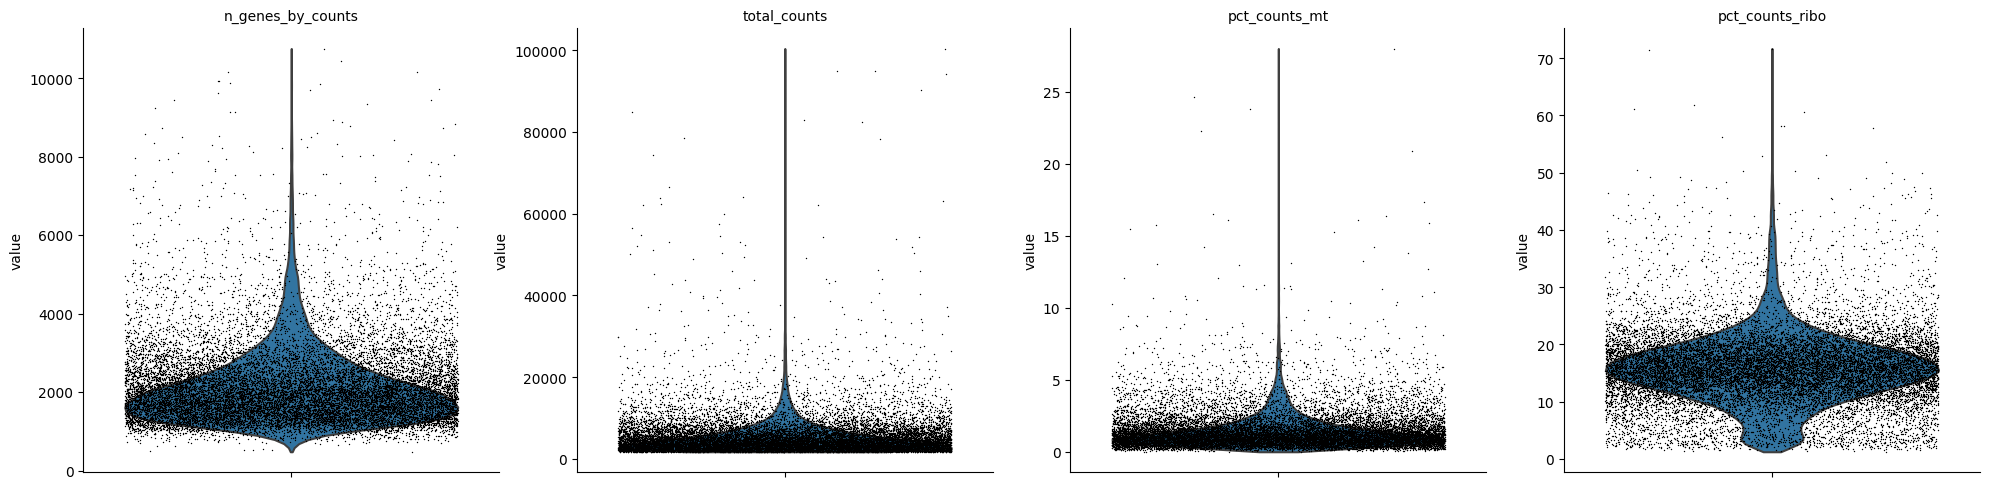

In [ ]:
with rc_context({'figure.figsize': (20, 20)}):
  sc.pl.violin(pip, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],jitter=0.4, multi_panel=True)

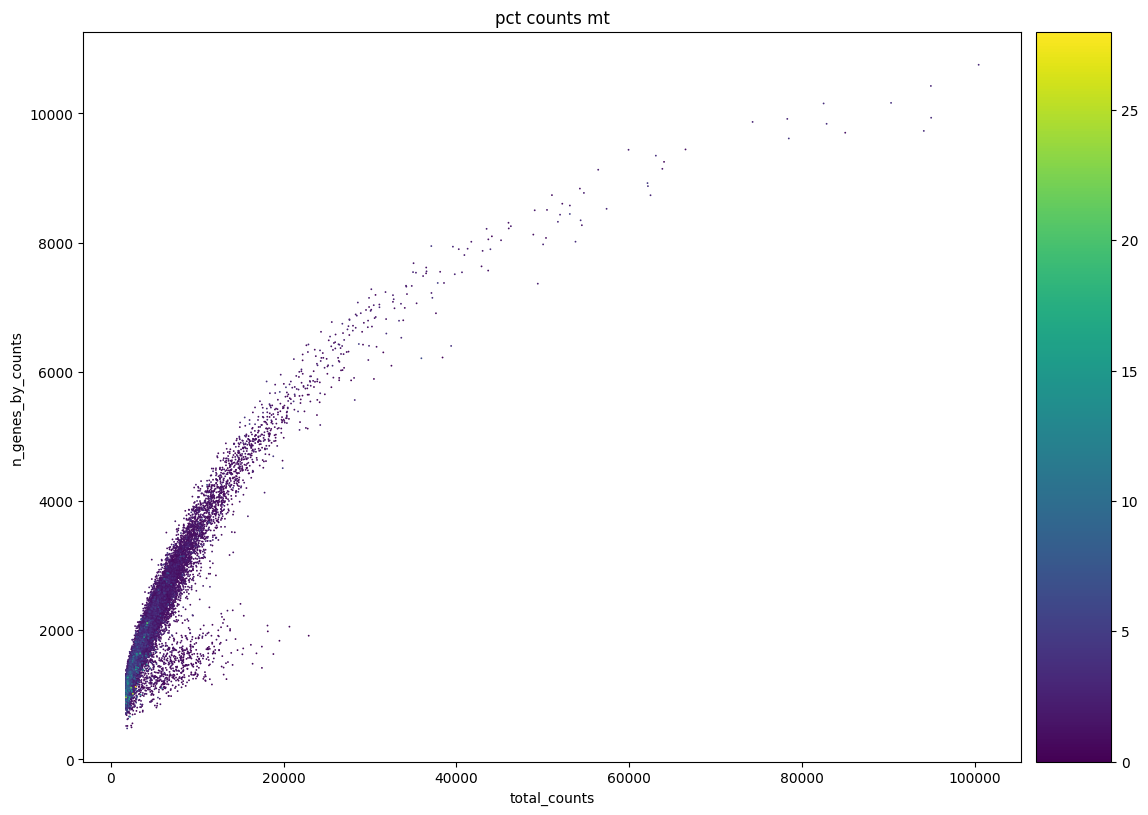

In [ ]:
with rc_context({'figure.figsize': (10, 10)}):
  sc.pl.scatter(pip, 'total_counts', 'n_genes_by_counts', color='pct_counts_mt', use_raw=False)

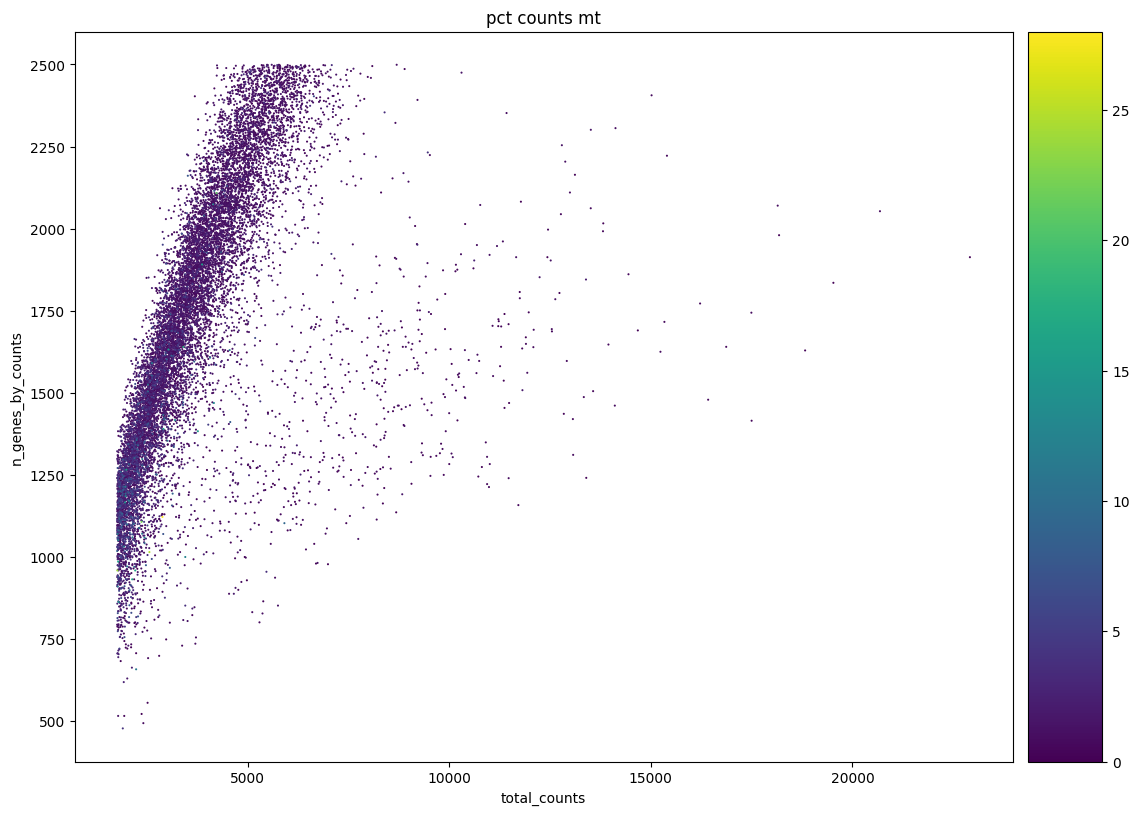

In [ ]:
x = pip.copy()[pip.obs['n_genes_by_counts']<2500, : ]

with rc_context({'figure.figsize': (10, 10)}):
  sc.pl.scatter(x, 'total_counts', 'n_genes_by_counts', color='pct_counts_mt', use_raw=False)

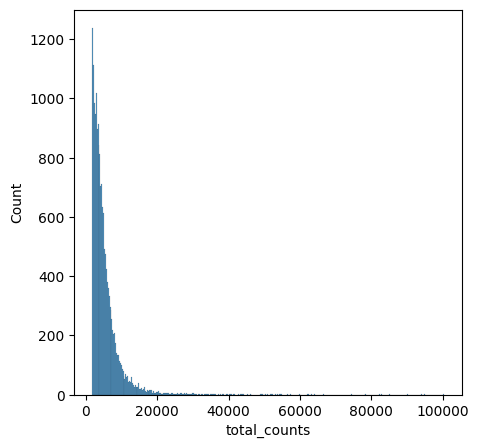

In [ ]:
with rc_context({'figure.figsize': (5, 5)}):
  sns.histplot(pip.obs["total_counts"])

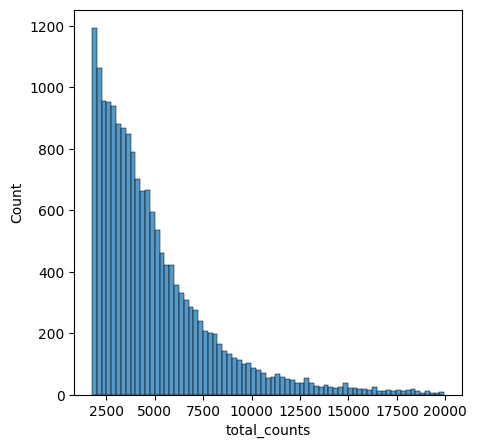

In [ ]:
total_counts_20000 = pip[pip.obs['total_counts']<20000, : ]
with rc_context({'figure.figsize': (5, 5)}):
  sns.histplot(total_counts_20000.obs["total_counts"])

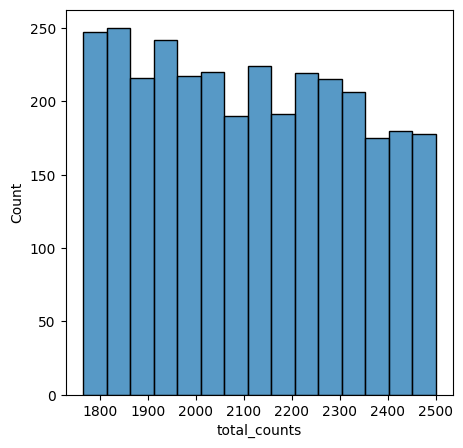

In [ ]:
total_counts_2500 = pip[pip.obs['total_counts']<2500, : ]
with rc_context({'figure.figsize': (5, 5)}):
  sns.histplot(total_counts_2500.obs["total_counts"])

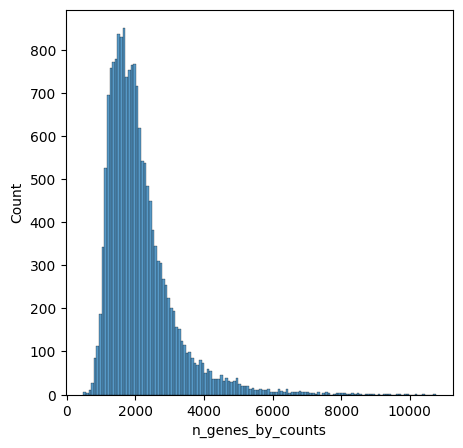

In [ ]:
with rc_context({'figure.figsize': (5, 5)}):
  sns.histplot(pip.obs["n_genes_by_counts"])

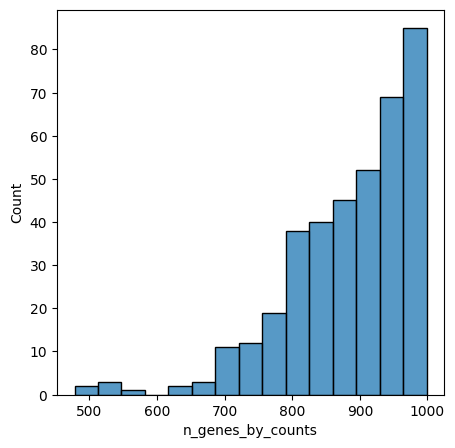

In [ ]:
n_genes_1000 = pip[pip.obs['n_genes_by_counts']<1000, : ]

with rc_context({'figure.figsize': (5, 5)}):
    sns.histplot(n_genes_1000.obs["n_genes_by_counts"])

In [ ]:
def removeMitoRibo(annData):
    # function that removes all ribosomal and mitochondria genes; adapted from CSCB_2023_scRNAseq.ipynb
    adata = annData.copy()
    mito_genes = adata.var_names.str.startswith('MT-')
    ribo_genes = adata.var_names.str.startswith(("MRPS","MRPL", "RPS", "RPL"))
    malat_gene = adata.var_names.str.startswith("MALAT1")
    remove = np.add(mito_genes, ribo_genes)
    remove = np.add(remove, malat_gene)
    keep = np.invert(remove)
    adata = adata[:,keep].copy()
    return adata

In [ ]:
pip = removeMitoRibo(pip)
pip = pip[pip.obs['total_counts'] < 20000, :]
pip = pip[pip.obs['pct_counts_mt'] < 10, :]
# filter for percent ribo > 0.05
pip = pip[pip.obs['pct_counts_ribo'] < 50, :]
pip = pip[pip.obs['n_genes_by_counts'] >= 700, :]
pip = pip[pip.obs['n_genes_by_counts'] <= 8000, :]

In [ ]:
pip

View of AnnData object with n_obs × n_vars = 17362 × 59507
    obs: 0, 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt'
    var: 0, 1, 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [ ]:
pip.obs_names = pip.obs[0]

In [ ]:
pip.obs = pip.obs.iloc[:, 1:]

In [ ]:
pip.var = pip.var.iloc[:,2:]

In [ ]:
pip.write("./pip_qc.h5ad")

In [ ]:
tenx.var_names_make_unique()

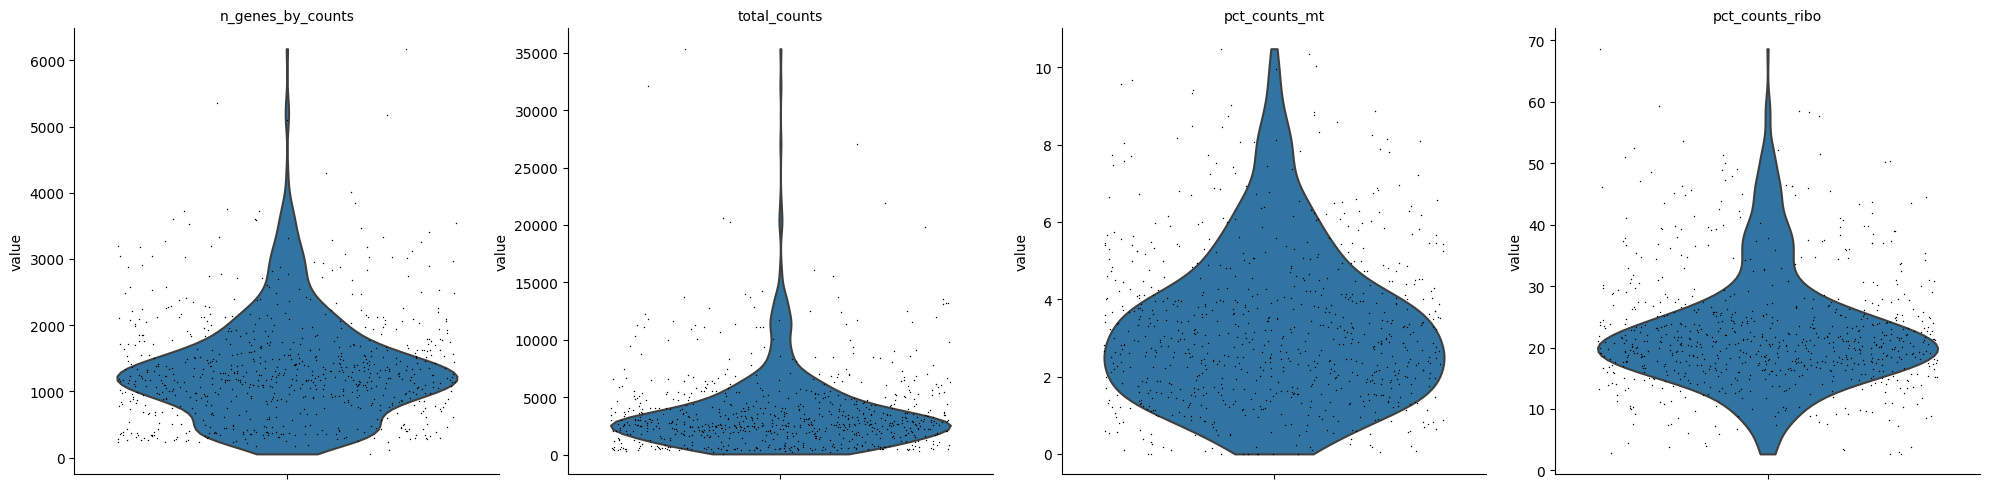

In [ ]:
with rc_context({'figure.figsize': (20, 20)}):
  sc.pl.violin(tenx, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],jitter=0.4, multi_panel=True)

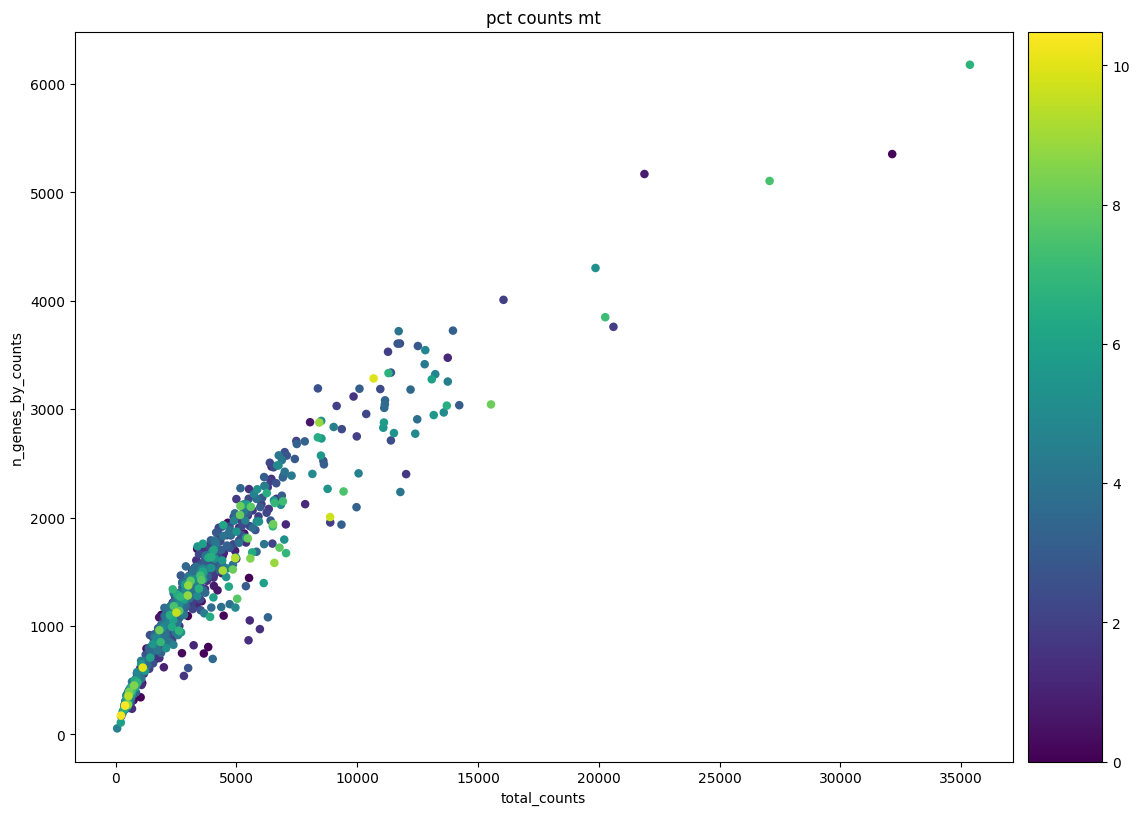

In [ ]:
with rc_context({'figure.figsize': (10, 10)}):
  sc.pl.scatter(tenx, 'total_counts', 'n_genes_by_counts', color='pct_counts_mt', use_raw=False)

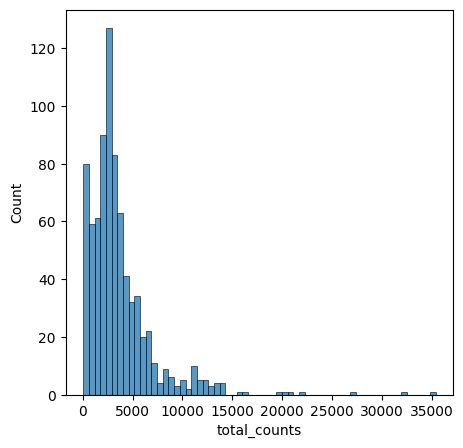

In [ ]:
with rc_context({'figure.figsize': (5, 5)}):
  sns.histplot(tenx.obs["total_counts"])

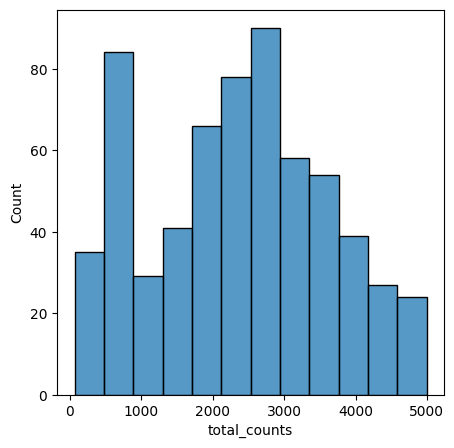

In [ ]:
total_counts_5000 = tenx[tenx.obs['total_counts']<5000, : ]
with rc_context({'figure.figsize': (5, 5)}):
  sns.histplot(total_counts_5000.obs["total_counts"])

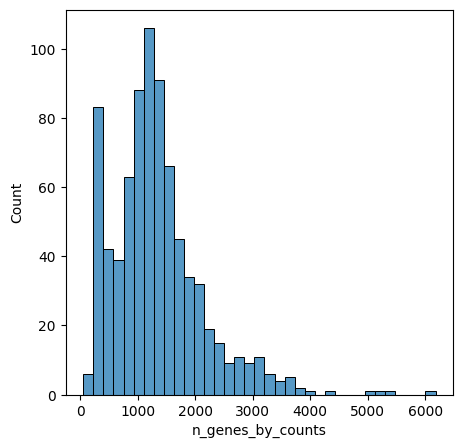

In [ ]:
with rc_context({'figure.figsize': (5, 5)}):
  sns.histplot(tenx.obs["n_genes_by_counts"])

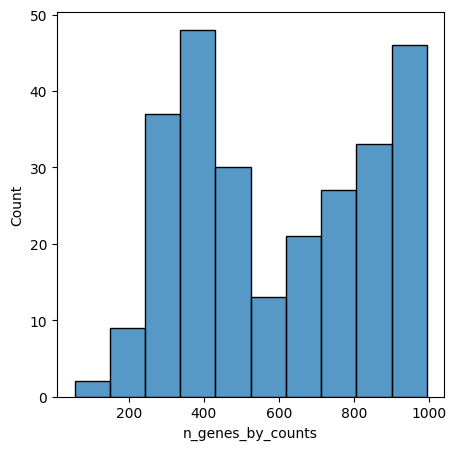

In [ ]:
n_genes_1000 = tenx[tenx.obs['n_genes_by_counts']<1000, : ]

with rc_context({'figure.figsize': (5, 5)}):
    sns.histplot(n_genes_1000.obs["n_genes_by_counts"])

In [ ]:
tenx

AnnData object with n_obs × n_vars = 792 × 21823
    obs: 0, 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt'
    var: 0, 1, 2, 'symbol', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [ ]:
tenx = removeMitoRibo(tenx)
tenx = tenx[tenx.obs['total_counts'] < 20000, :]
tenx = tenx[tenx.obs['total_counts'] > 1000, :]
tenx = tenx[tenx.obs['pct_counts_mt'] < 10, :]
# filter for percent ribo > 0.05
tenx = tenx[tenx.obs['pct_counts_ribo'] < 50, :]
tenx = tenx[tenx.obs['n_genes_by_counts'] >= 600, :]
tenx = tenx[tenx.obs['n_genes_by_counts'] <= 5000, :]

In [ ]:
tenx

View of AnnData object with n_obs × n_vars = 640 × 21625
    obs: 0, 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt'
    var: 0, 1, 2, 'symbol', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [ ]:
tenx.obs_names = tenx.obs[0]

In [ ]:
tenx.obs = tenx.obs.iloc[:, 1:]

In [ ]:
tenx.var = tenx.var.iloc[:,3:]

In [ ]:
tenx.var

symbol     mt   ribo  n_cells_by_counts  \
symbol                                                              
ENSG00000238009  ENSG00000238009  False  False                  2   
ENSG00000239945  ENSG00000239945  False  False                  0   
LINC01409              LINC01409  False  False                  4   
FAM87B                    FAM87B  False  False                  0   
LINC00115              LINC00115  False  False                  5   
...                          ...    ...    ...                ...   
ENSG00000278384  ENSG00000278384  False  False                  6   
ENSG00000276345  ENSG00000276345  False  False                 34   
ENSG00000277856  ENSG00000277856  False  False                  1   
ENSG00000275063  ENSG00000275063  False  False                  0   
ENSG00000271254  ENSG00000271254  False  False                 10   

                 mean_counts  pct_dropout_by_counts  total_counts  
symbol                                                             
ENSG00000238009     0.002525              99.747475           2.0  
ENSG00000239945     0.000000             100.000000           0.0  
LINC01409           0.005051              99.494949           4.0  
FAM87B              0.000000             100.000000           0.0  
LINC00115           0.006313              99.368687           5.0  
...                      ...                    ...           ...  
ENSG00000278384     0.007576              99.242424           6.0  
ENSG00000276345     0.049242              95.707071          39.0  
ENSG00000277856     0.001263              99.873737           1.0  
ENSG00000275063     0.000000             100.000000           0.0  
ENSG00000271254     0.015152              98.737374          12.0  

[21625 rows x 7 columns]

In [ ]:
tenx.write("./tenx_qc.h5ad")

# Normalisation and Feature Engineering






In [ ]:
pip_qc = sc.read_h5ad("pip_qc.h5ad")
tenx_qc = sc.read_h5ad("tenx_qc.h5ad")

In [ ]:
pip_qc

AnnData object with n_obs × n_vars = 17362 × 59507
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [ ]:
markers = {
    'Fibroblast': ["DCN", "MMP2", "PDPN", "PDGFRA", "B"],
    'LEP1': ["ALDH1A3","LTF", "PROM1", "ESR1", "PGR"],
    'LEP2': ["KRT19", "ELF3",	"MUC1",	"AGR2",	"ANKRD30A",	"TFF3",	"ESR1",	"PGR"],
    "Luminal Epithelium":["EPCAM", "KRT7", "KRT19"],
    "Other Epithelium":["EPCAM", "KRT14", "KRT17"],
    "T Cells": ["CD3E"],
    "Other immune": ["KIT", "CPA3"],
    "B cells (immature)": ["MS4A1","CD20"],
    "B cells (mature)": ["IGHA1", "JCHAIN"],
    'MEP': ["KRT14",	"KRT17",	"TP63",	"ACTA2"],
    'DC': ["LY75",	"CCR7", "HLA-DRA", "HLA-DRB1", "CD74"],
    'Vascular Acc': ["RGS5"],
    'Endothelial': ["ANGPT2",	"CDH5",	"CLDN5", "EMCN"],
    'Macrophage': ["CD14",	"CD16",	"CD64",	"CD68",	"CD71", "CCL3", 'IFI30', 'LAPTM5'],
    'Lymphocyte': ["CD52",	"CXCR4"	, "CD3D",	"CD8A",	"PTPRC"],
}


In [ ]:
def filterGenebyCellCount(annData, threshold=5):
  return sc.pp.filter_genes(annData, min_cells=threshold, inplace=False)

def normalizeLogp1(annData):
  sc.pp.normalize_total(annData, target_sum=1e4)
  sc.pp.log1p(annData)

In [ ]:
allMarkers = [gene for key, value in markers.items() for gene in value] #compiling all genes in 4 cell states
allGenes = list(pip_qc.var.index) #getting name of all genes in dataaset
allMarkers = [x for x in allMarkers if x in allGenes] #getting subset of markers genes that can be found in data
markerIndex = [allGenes.index(gene) for gene in allMarkers] #getting index of abovementioned marker genes

In [ ]:
gene_subset,counts = filterGenebyCellCount(pip_qc)
for i in markerIndex:
  if gene_subset[i] == False:
    gene_subset[i] = True
pip_qc = pip_qc[:, gene_subset]
normalizeLogp1(pip_qc)
pip_qc

AnnData object with n_obs × n_vars = 17362 × 32136
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [ ]:
highly_variable_genes = sc.pp.highly_variable_genes(pip_qc, min_mean=0.0125, max_mean=4, min_disp=0.25, inplace = False)
highlyVariable = list(highly_variable_genes['highly_variable'])
allGenes2 = list(pip_qc.var.index)
markerIndex2 = [allGenes2.index(gene) for gene in allMarkers]
for i in markerIndex2:
  if highlyVariable[i] == False:
    highlyVariable[i] = True
pip_qc = pip_qc[:, highlyVariable]
pip_qc

View of AnnData object with n_obs × n_vars = 17362 × 6282
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [ ]:
allMarkers = [gene for key, value in markers.items() for gene in value] #compiling all genes in 4 cell states
allGenes = list(tenx_qc.var.index) #getting name of all genes in dataaset
allMarkers = [x for x in allMarkers if x in allGenes] #getting subset of markers genes that can be found in data
markerIndex = [allGenes.index(gene) for gene in allMarkers] #getting index of abovementioned marker genes

In [ ]:
gene_subset,counts = filterGenebyCellCount(tenx_qc)
for i in markerIndex:
  if gene_subset[i] == False:
    gene_subset[i] = True
tenx_qc = tenx_qc[:, gene_subset]
normalizeLogp1(tenx_qc)
tenx_qc

AnnData object with n_obs × n_vars = 640 × 12473
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt'
    var: 'symbol', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [ ]:
highly_variable_genes = sc.pp.highly_variable_genes(tenx_qc, min_mean=0.0125, max_mean=4, min_disp=0.25, inplace = False)
highlyVariable = list(highly_variable_genes['highly_variable'])
allGenes2 = list(pip_qc.var.index)
markerIndex2 = [allGenes2.index(gene) for gene in allMarkers]
for i in markerIndex2:
  if highlyVariable[i] == False:
    highlyVariable[i] = True
tenx_qc = tenx_qc[:, highlyVariable]
tenx_qc

View of AnnData object with n_obs × n_vars = 640 × 3596
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt'
    var: 'symbol', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

# Concatenation, Batch Effect Correction and Manual Annotation

In [ ]:
pip_sub = sc.pp.subsample(pip_qc, n_obs = tenx_qc.obs.shape[0], copy=True)

In [ ]:
pip_sub

AnnData object with n_obs × n_vars = 640 × 6282
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [ ]:
tenx_sub = tenx_qc.copy()

In [ ]:
var_names = pip_sub.var_names.intersection(tenx_sub.var_names)
pip_sub = pip_sub[:, var_names]
tenx_sub = tenx_sub[:, var_names]

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


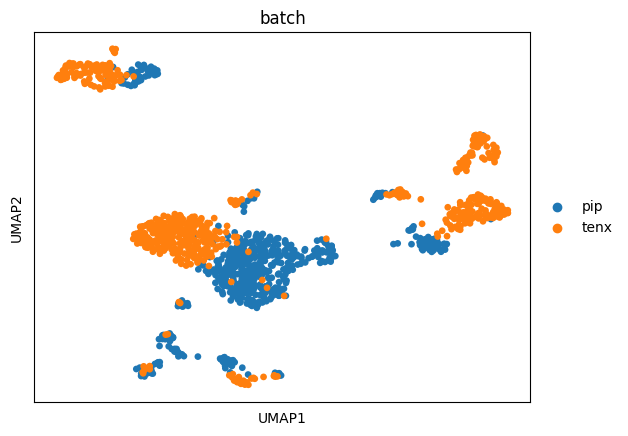

In [ ]:
concat = pip_sub.concatenate(tenx_sub, batch_categories=['pip', 'tenx'])
sc.pp.pca(concat)
sc.pp.neighbors(concat)
sc.tl.umap(concat)
sc.pl.umap(concat, color=['batch'], palette=sc.pl.palettes.vega_20_scanpy)

In [ ]:
import scanpy.external as sce

sce.pp.bbknn(concat, batch_key='batch', n_pcs=30)  # running bbknn 1.3.6

# then run umap on the integrated space
sc.tl.umap(concat)

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


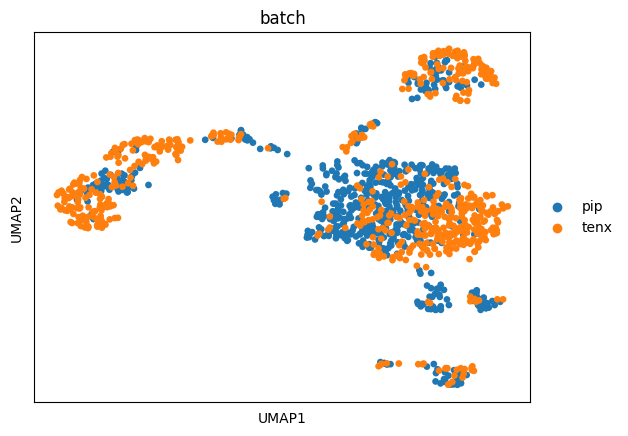

In [ ]:
sc.pl.umap(concat, color=['batch'], palette=sc.pl.palettes.vega_20_scanpy)

In [ ]:
sc.pp.scale(concat, max_value=10)
npcs = 50
nknns = 10
sc.tl.pca(concat, n_comps=100)
sc.pp.neighbors(concat, n_neighbors=nknns, n_pcs=npcs)
sc.tl.umap(concat,.7)
sc.tl.leiden(concat,resolution=0.2, key_added="clusters")

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=100
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Leiden clustering
    finished: found 9 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


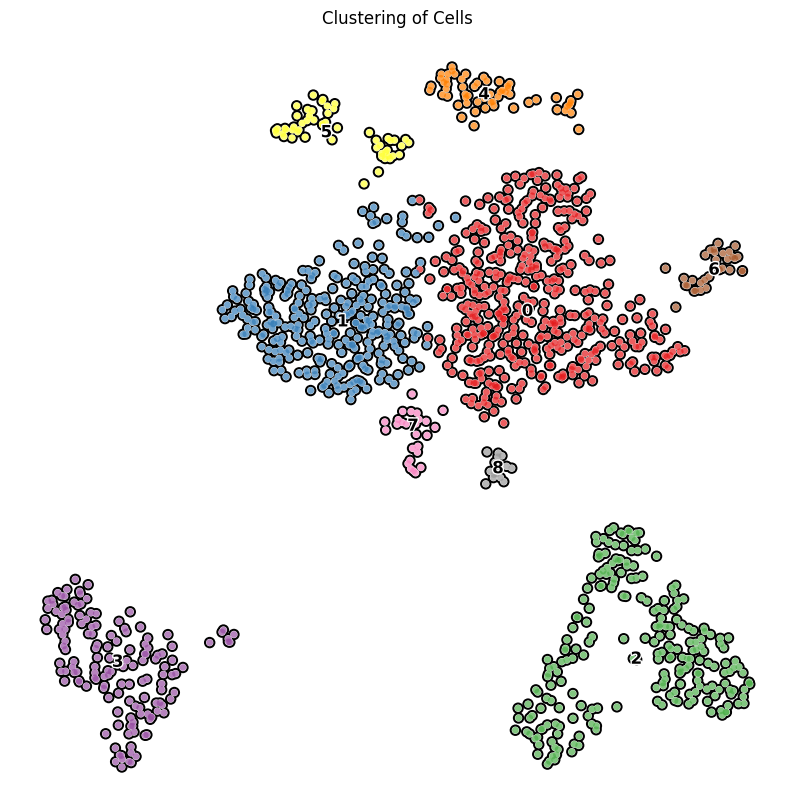

In [ ]:
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(concat, color='clusters', add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False,
               title='Clustering of Cells', palette='Set1')

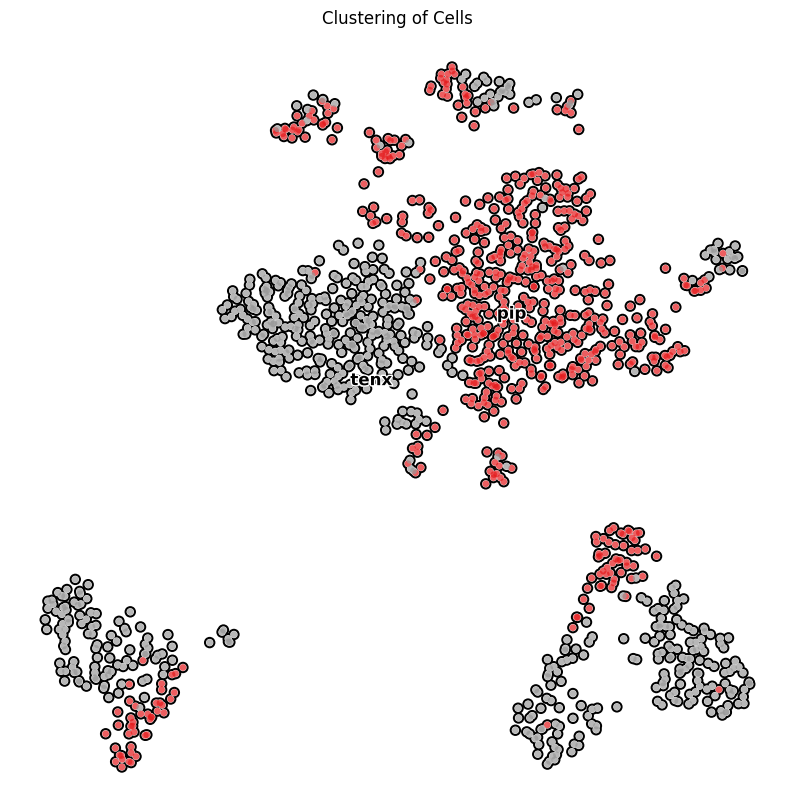

In [ ]:
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(concat, color='batch', add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False,
               title='Clustering of Cells', palette='Set1')

In [ ]:
markers_pip = markers.copy()

for key, value in markers_pip.items():
  markers_pip[key] = [x for x in value if x in concat.var_names]

    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_clusters']`
categories: 0, 1, 2, etc.
var_group_labels: Fibroblast, LEP1, LEP2, etc.


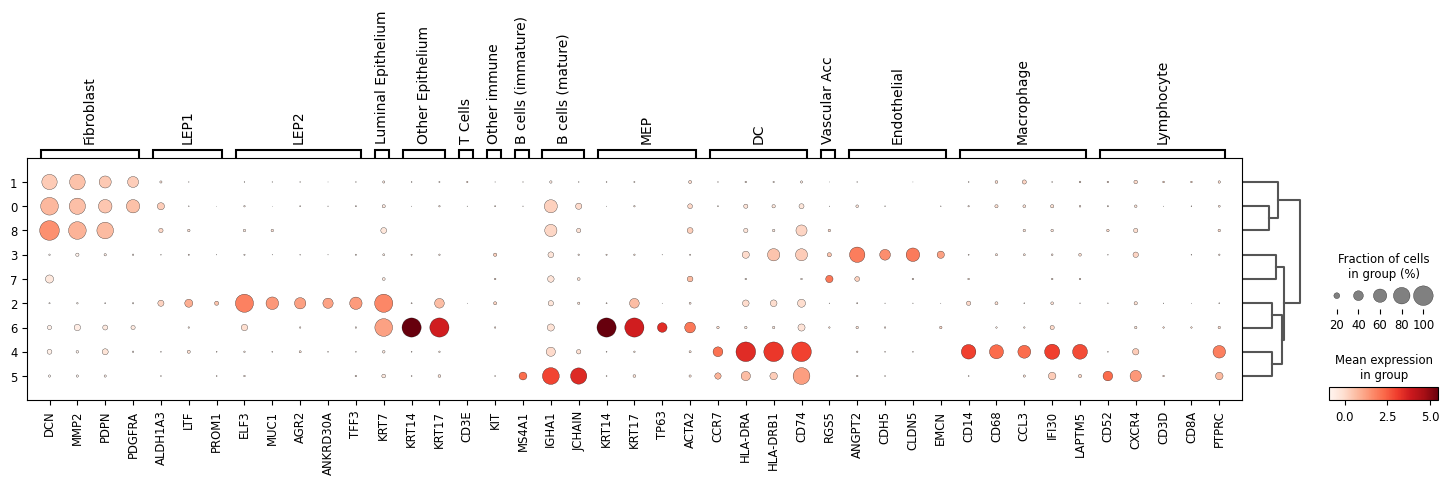

In [ ]:
sc.pl.dotplot(concat, markers_pip, 'clusters', dendrogram=True)

In [ ]:
cluster2annotation = {
    '0':'Fibroblast',
    '1':'Fibroblast',
    '2':'LEP2',
    '3':'Endothelial',
    '4':'DC/Macorphage',
    '5':'Mature B',
    '6':'MEP',
    '7': 'Vascular Acc',
    '8':'Fibroblast',
}
concat.obs['manual annotation'] = concat.obs['clusters'].map(cluster2annotation).astype('category')

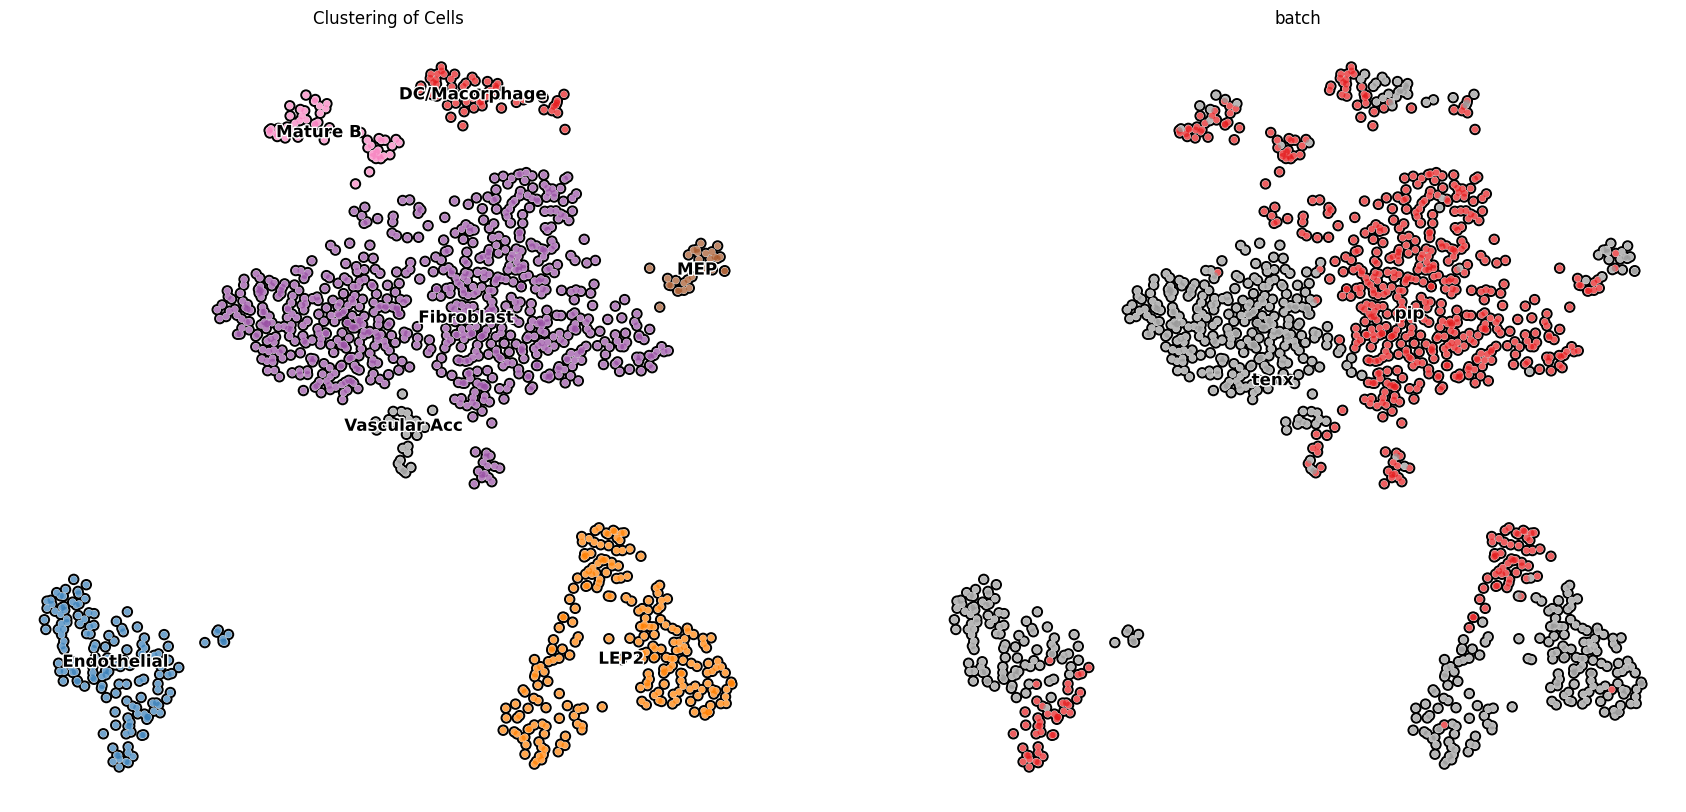

In [ ]:
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(concat, color=['manual annotation', 'batch'], add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False,
               title='Clustering of Cells', palette='Set1')

#Clustering and Annotation of PIP-Seq Data for BBKNN & pySCN



In [ ]:
pip_train = pip_qc.copy()

In [ ]:
sc.pp.scale(pip_train, max_value=10)
npcs = 70
nknns = 30
sc.tl.pca(pip_train, n_comps=100)
sc.pp.neighbors(pip_train, n_neighbors=nknns, n_pcs=npcs)
sc.tl.umap(pip_train,.7)
sc.tl.leiden(pip_train,resolution=0.30, key_added="clusters")

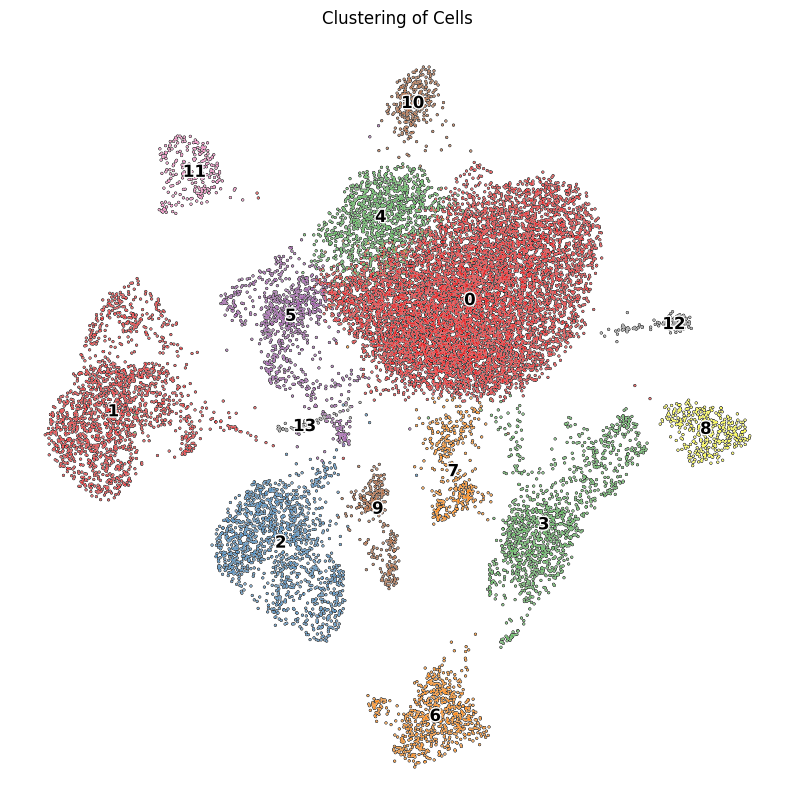

In [ ]:
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(pip_train, color='clusters', add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False,
               title='Clustering of Cells', palette='Set1')

In [ ]:
markers_pip = markers.copy()

for key, value in markers_pip.items():
  markers_pip[key] = [x for x in value if x in pip_train.var_names]

In [ ]:
markers_pip

{'Fibroblast': ['DCN', 'MMP2', 'PDPN', 'PDGFRA'],
 'LEP1': ['ALDH1A3', 'LTF', 'PROM1', 'ESR1', 'PGR'],
 'LEP2': ['KRT19', 'ELF3', 'MUC1', 'AGR2', 'ANKRD30A', 'TFF3', 'ESR1', 'PGR'],
 'Luminal Epithelium': ['EPCAM', 'KRT7', 'KRT19'],
 'Other Epithelium': ['EPCAM', 'KRT14', 'KRT17'],
 'T Cells': ['CD3E'],
 'Other immune': ['KIT', 'CPA3'],
 'B cells (immature)': ['MS4A1'],
 'B cells (mature)': ['IGHA1', 'JCHAIN'],
 'MEP': ['KRT14', 'KRT17', 'TP63', 'ACTA2'],
 'DC': ['LY75', 'CCR7', 'HLA-DRA', 'HLA-DRB1', 'CD74'],
 'Vascular Acc': ['RGS5'],
 'Endothelial': ['ANGPT2', 'CDH5', 'CLDN5', 'EMCN'],
 'Macrophage': ['CD14', 'CD68', 'CCL3', 'IFI30', 'LAPTM5'],
 'Lymphocyte': ['CD52', 'CXCR4', 'CD3D', 'CD8A', 'PTPRC']}

categories: 0, 1, 2, etc.
var_group_labels: Fibroblast, LEP1, LEP2, etc.


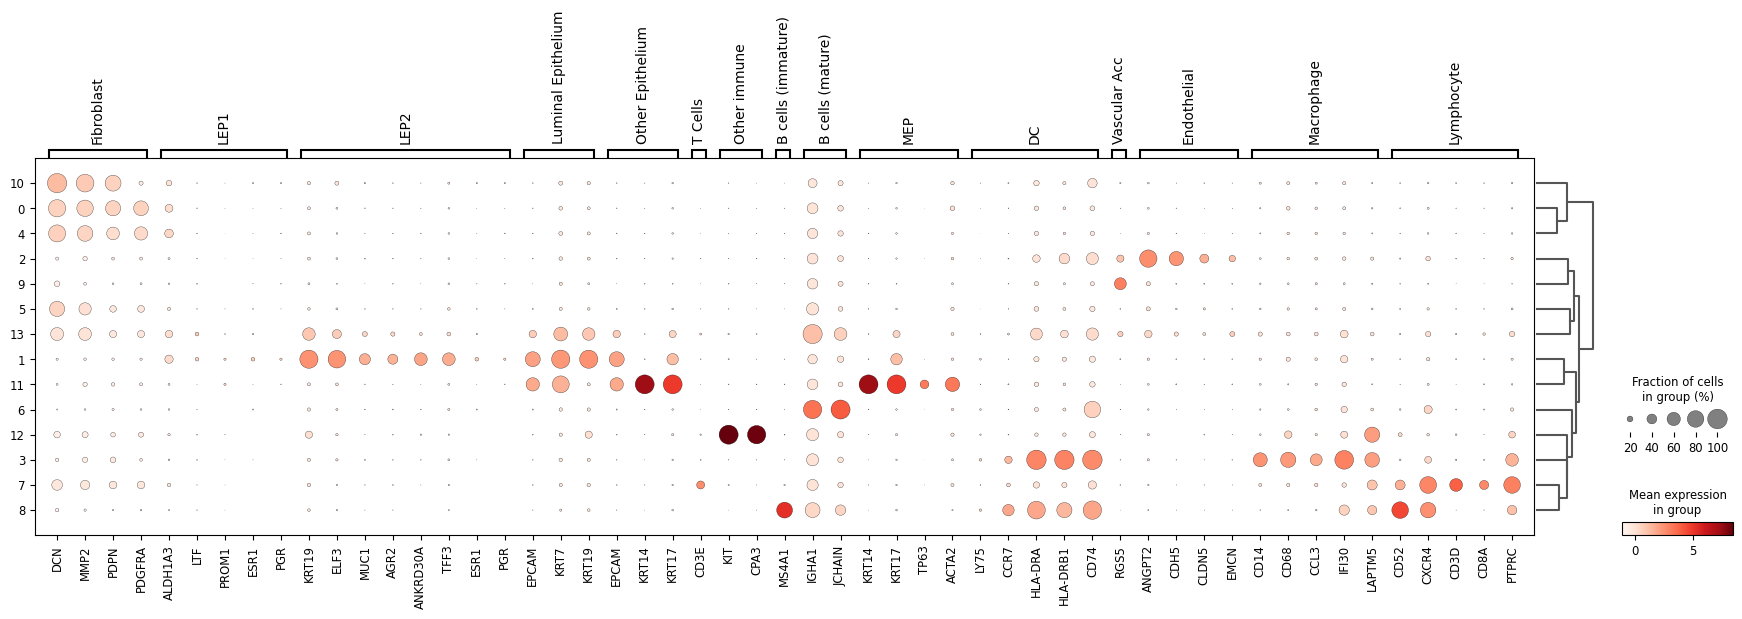

In [ ]:
sc.pl.dotplot(pip_train, markers_pip, 'clusters', dendrogram=True)

In [ ]:
cluster2annotation = {
    '0':'Fibroblast',
    '1':'LEP2',
    '2':'Endothelial',
    '3':'DC/Macrophage',
    '4':'Fibroblast',
    '5':'Other',
    '6':'Mature B',
    '7': 'Lymphocyte',
    '8':'Immature B',
    '9':'Vascular Acc',
    '10':'Fibroblast',
    '11':'MEP',
    '12':'Other Immune',
    '13':'Other'
}
pip_train.obs['truth'] = pip_train.obs['clusters'].map(cluster2annotation).astype('category')

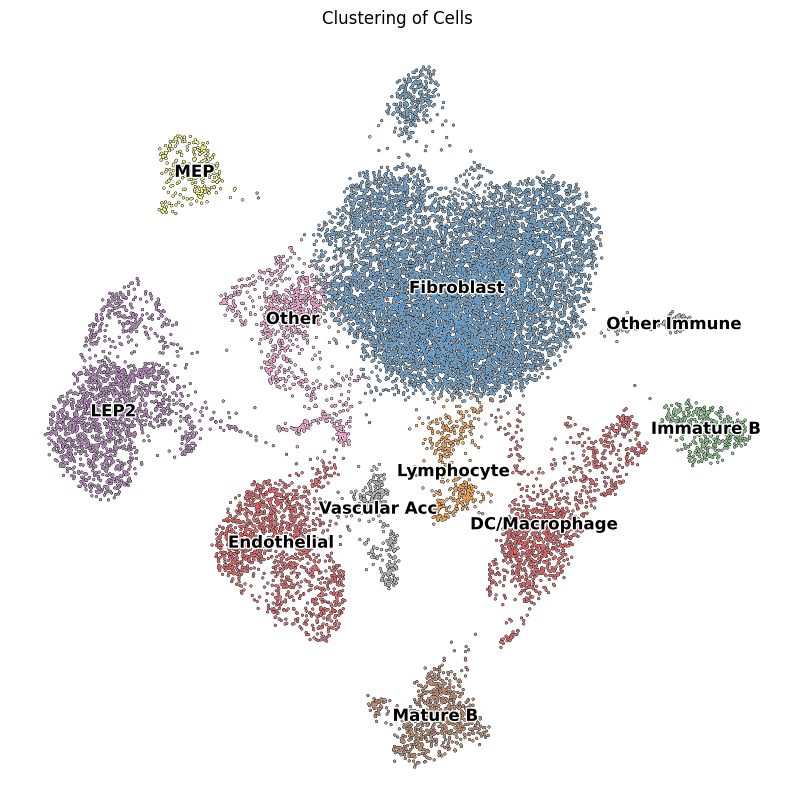

In [ ]:
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(pip_train, color='truth', add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False,
               title='Clustering of Cells', palette='Set1')

# BBKNN

In [ ]:
tenx_bbknn = tenx_qc.copy()

In [ ]:
var_names = pip_train.var_names.intersection(tenx_bbknn.var_names)
pip_train = pip_train[:, var_names]
tenx_bbknn = tenx_bbknn[:, var_names]

computing PCA
    with n_comps=50
    finished (0:00:47)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


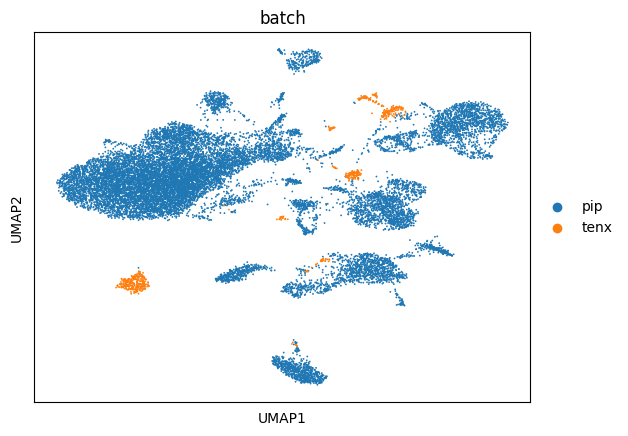

In [ ]:
bbknn_concat = pip_train.concatenate(tenx_bbknn, batch_categories=['pip', 'tenx'])
sc.pp.pca(bbknn_concat)
sc.pp.neighbors(bbknn_concat)
sc.tl.umap(bbknn_concat)
sc.pl.umap(bbknn_concat, color=['batch'], palette=sc.pl.palettes.vega_20_scanpy)

In [ ]:
sce.pp.bbknn(bbknn_concat, batch_key='batch', n_pcs=30)  # running bbknn 1.3.6

# then run umap on the integrated space
sc.tl.umap(bbknn_concat)

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


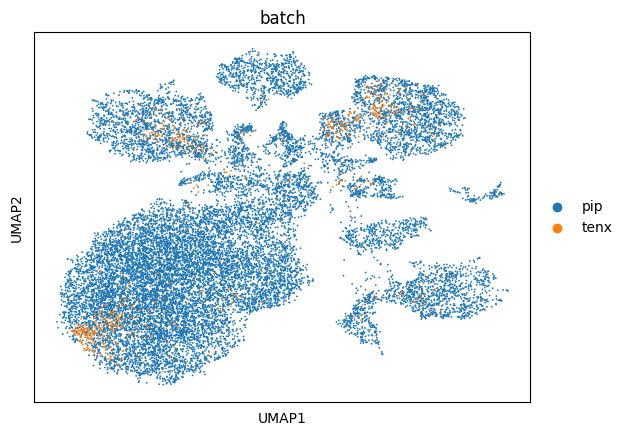

In [ ]:
sc.pl.umap(bbknn_concat, color=['batch'], palette=sc.pl.palettes.vega_20_scanpy)

In [ ]:
bbknn_concat.obs

n_genes_by_counts  total_counts  total_counts_ribo  \
CACTAATTAGCTCAGT-pip                  2070  18147.000000        1989.277832   
ACCGAACTACCCATAA-pip                  1835  19528.000000         968.076050   
AAAAAAAGAACTCCCT-pip                  4806  18090.000000        3802.300537   
ATTGAAGACATGCCTT-pip                  1744  17494.001953        1159.166626   
AAAAAGAGCATAATCG-pip                  4853  18351.000000        3179.046631   
...                                    ...           ...                ...   
TTTCCTCTCCCTGGTT-3-tenx               1785   5120.000000         897.000000   
TTTCGATGTTGCGAAG-3-tenx               1175   2524.000000         595.000000   
TTTGACTCAGTTGGTT-3-tenx               1637   4249.000000         999.000000   
TTTGACTTCTTCCCGA-3-tenx               1783   4334.000000         815.000000   
TTTGTTGTCGGAATTC-3-tenx                925   1620.000000         330.000000   

                         pct_counts_ribo  total_counts_mt  pct_counts_mt  \
CACTAATTAGCTCAGT-pip           10.962021       166.000000       0.914752   
ACCGAACTACCCATAA-pip            4.957374        48.000000       0.245801   
AAAAAAAGAACTCCCT-pip           21.018797       658.281494       3.638925   
ATTGAAGACATGCCTT-pip            6.626081       145.666672       0.832666   
AAAAAGAGCATAATCG-pip           17.323561       145.772736       0.794359   
...                                  ...              ...            ...   
TTTCCTCTCCCTGGTT-3-tenx        17.519531        64.000000       1.250000   
TTTCGATGTTGCGAAG-3-tenx        23.573692         1.000000       0.039620   
TTTGACTCAGTTGGTT-3-tenx        23.511414       106.000000       2.494705   
TTTGACTTCTTCCCGA-3-tenx        18.804798        97.000000       2.238117   
TTTGTTGTCGGAATTC-3-tenx        20.370371        51.000000       3.148148   

                        clusters       truth batch  
CACTAATTAGCTCAGT-pip           6    Mature B   pip  
ACCGAACTACCCATAA-pip           6    Mature B   pip  
AAAAAAAGAACTCCCT-pip           1        LEP2   pip  
ATTGAAGACATGCCTT-pip           6    Mature B   pip  
AAAAAGAGCATAATCG-pip           0  Fibroblast   pip  
...                          ...         ...   ...  
TTTCCTCTCCCTGGTT-3-tenx      NaN         NaN  tenx  
TTTCGATGTTGCGAAG-3-tenx      NaN         NaN  tenx  
TTTGACTCAGTTGGTT-3-tenx      NaN         NaN  tenx  
TTTGACTTCTTCCCGA-3-tenx      NaN         NaN  tenx  
TTTGTTGTCGGAATTC-3-tenx      NaN         NaN  tenx  

[18002 rows x 9 columns]

In [ ]:
adata_ref = bbknn_concat[bbknn_concat.obs.batch == 'pip']

In [ ]:
adata_query = bbknn_concat[bbknn_concat.obs.batch == 'tenx']

In [ ]:
sc.tl.ingest(adata_query, adata_ref, obs='truth')

running ingest
    finished (0:00:29)


In [ ]:
adata_ref_sub = sc.pp.subsample(adata_ref, n_obs=640, copy=True)

In [ ]:
adata_concat = adata_ref_sub.concatenate(adata_query, batch_categories=['pip', 'tenx'])


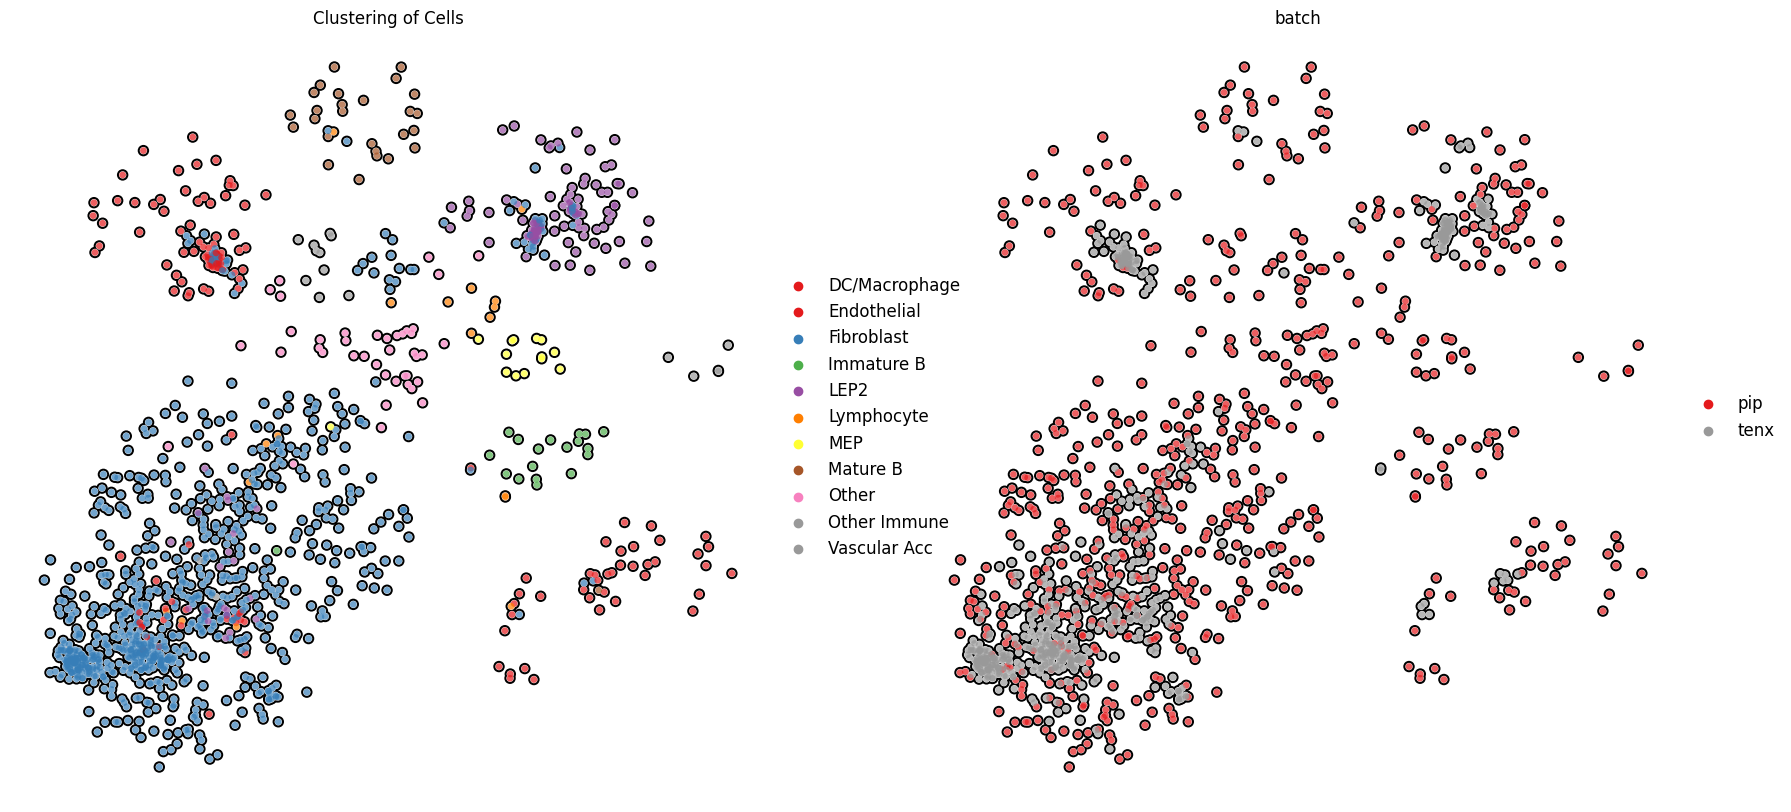

In [ ]:
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata_concat, color=['truth', 'batch'], add_outline=True,
               legend_fontsize=12, legend_fontoutline=2, frameon=False,
               title='Clustering of Cells', palette='Set1')

# pySCN

## Installing Packages and Importing them

In [ ]:
pip install pandas numpy scanpy sklearn statsmodels scipy matplotlib seaborn umap-learn

In [ ]:
!pip install git+https://github.com/pcahan1/PySingleCellNet/

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import scanpy as sc
import scipy as sp
import numpy as np
# Loompy is only needed if using loom files
# import loompy 
import anndata

sc.settings.verbosity = 3 
sc.logging.print_header()

import pySingleCellNet as pySCN

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.22.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.10


## Train Classifier

In [ ]:
train = pip_qc.copy()
train.obs['truth'] = pip_train.obs.truth
predict = tenx_qc.copy()

In [ ]:
var_names = predict.var_names.intersection(train.var_names)
predict = predict[:, var_names]
train = train[:, var_names]

In [ ]:
[cgenesA, xpairs, tspRF] = pySCN.scn_train(train, nTopGenes = 100, nRand = 100, nTrees = 1000 ,nTopGenePairs = 100, dLevel = "truth", stratify=True, limitToHVG=True)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
HVG
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Matrix normalized
There are  380  classification genes

DC/Macrophage
Endothelial
Fibroblast
Immature B
LEP2
Lymphocyte
MEP
Mature B
Other
Other Immune
Vascular Acc
There are 1060 top gene pairs

Finished pair transforming the data



In [ ]:
predictions = pySCN.scn_classify(predict, cgenesA, xpairs, tspRF, nrand = 0)

In [ ]:
predict.obs['predictions'] = predictions.obs.SCN_class

In [ ]:
pip_pyscn = sc.pp.subsample(train, n_obs=640, copy=True)
concat_pyscn = pip_pyscn.concatenate(predict, batch_categories=['pip', 'tenx'])

# Analysis of Cell Populations and Gene Expression using different Methods

In [ ]:
concat_pyscn.obs['label'] = [x.truth if x.batch=='pip' else x.predictions for _, x in concat_pyscn.obs.iterrows()]

In [ ]:
#BBKNN
adata_concat.obs.rename(columns = {'truth':'label'}, inplace = True)

In [ ]:
#manual annotation
concat.obs.rename(columns = {'manual annotation':'label'}, inplace = True)

In [ ]:
def proportion(obs):
  pip = obs[obs.obs['batch']=='pip']
  tenx = obs[obs.obs['batch']=='tenx']
  pip_prop = pip.obs.label.value_counts(normalize=True)
  tenx_prop = tenx.obs.label.value_counts(normalize=True)
  return pip_prop, tenx_prop

In [ ]:
print(proportion(concat))

(Fibroblast       0.692187
LEP2             0.084375
Mature B         0.070312
Endothelial      0.067187
DC/Macorphage    0.050000
MEP              0.020313
Vascular Acc     0.015625
Name: label, dtype: float64, Fibroblast       0.450000
LEP2             0.276562
Endothelial      0.165625
DC/Macorphage    0.040625
MEP              0.028125
Vascular Acc     0.025000
Mature B         0.014063
Name: label, dtype: float64)


In [ ]:
print(proportion(adata_concat))

(Fibroblast       0.589063
LEP2             0.087500
Endothelial      0.067187
Other            0.062500
DC/Macrophage    0.051562
Mature B         0.042188
Immature B       0.029687
Lymphocyte       0.023438
MEP              0.021875
Vascular Acc     0.015625
Other Immune     0.009375
Name: label, dtype: float64, Fibroblast       0.750000
LEP2             0.131250
Endothelial      0.084375
DC/Macrophage    0.026562
Lymphocyte       0.004687
Other            0.001563
Vascular Acc     0.001563
Name: label, dtype: float64)


In [ ]:
print(proportion(concat_pyscn))

(Fibroblast       0.589063
LEP2             0.087500
Endothelial      0.067187
Other            0.062500
DC/Macrophage    0.051562
Mature B         0.042188
Immature B       0.029687
Lymphocyte       0.023438
MEP              0.021875
Vascular Acc     0.015625
Other Immune     0.009375
Name: label, dtype: float64, Fibroblast       0.482812
LEP2             0.276562
Endothelial      0.140625
DC/Macrophage    0.040625
MEP              0.029687
Mature B         0.007812
Lymphocyte       0.007812
Vascular Acc     0.006250
Other            0.004687
Immature B       0.003125
Name: label, dtype: float64)


# Average Normalized Gene Expression



In [ ]:
def averageExpression(obs):
  pip = obs[obs.obs['batch']=='pip']
  tenx = obs[obs.obs['batch']=='tenx']
  pip_labels = pip.obs.label.unique()
  tenx_labels = tenx.obs.label.unique()
  labels = list(np.intersect1d(pip_labels, tenx_labels))
  expression = []
  for cell in labels:
    pip_cell = pip[pip.obs['label']==cell]
    tenx_cell = tenx[tenx.obs['label']==cell]
    pip_gene = pip_cell.X.T
    tenx_gene = tenx_cell.X.T
    if str(type(pip_gene)) == '<class \'scipy.sparse._csr.csr_matrix\'>':
      pip_gene = pip_gene.toarray()
    if str(type(tenx_gene)) == '<class \'scipy.sparse._csr.csr_matrix\'>':
      tenx_gene = tenx_gene.toarray()
    expression.append(([gene.mean() for gene in pip_gene], [gene.mean() for gene in tenx_gene]))
  return labels, expression

In [ ]:
labels, expression = averageExpression(concat_pyscn)

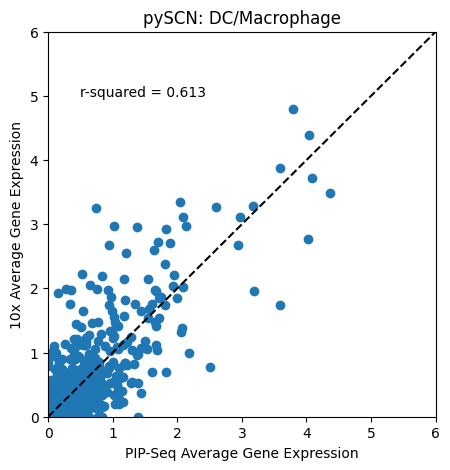

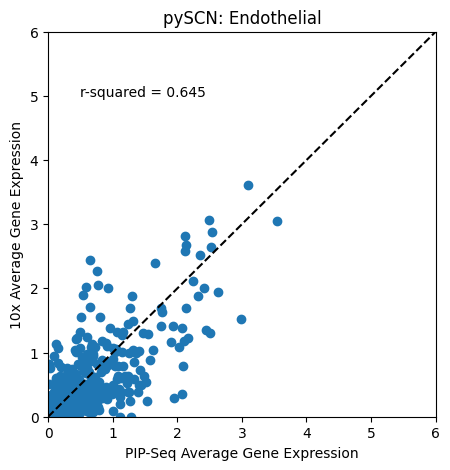

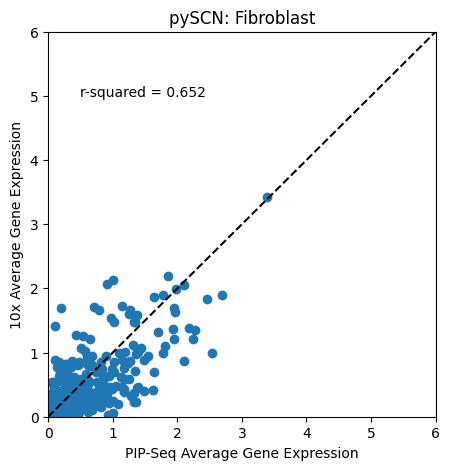

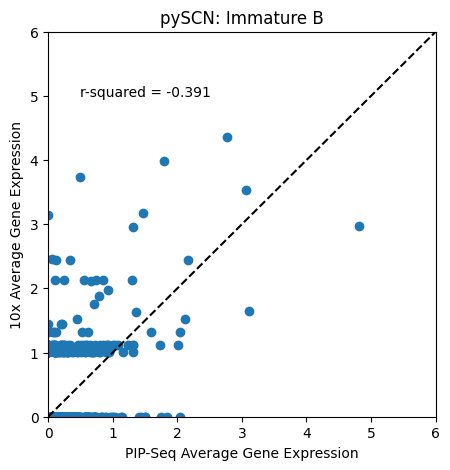

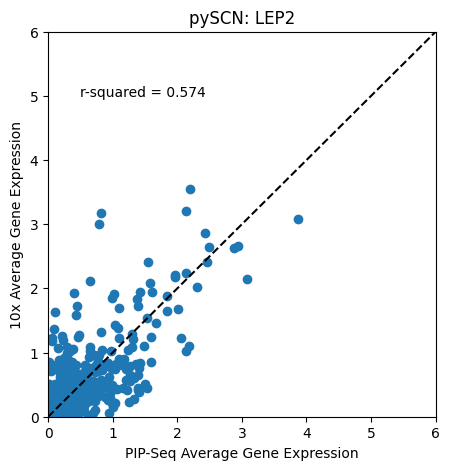

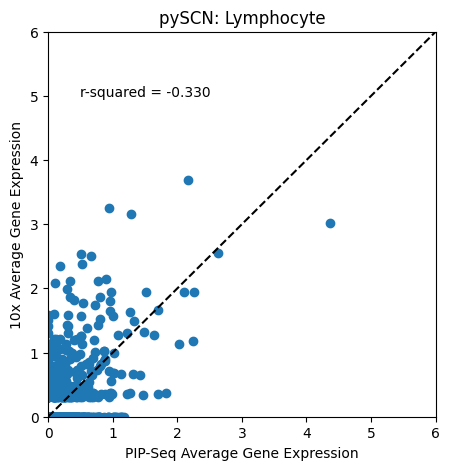

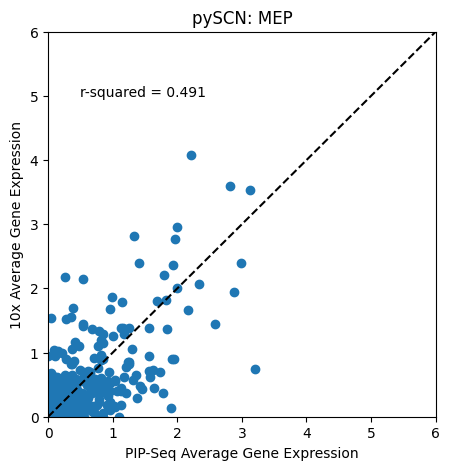

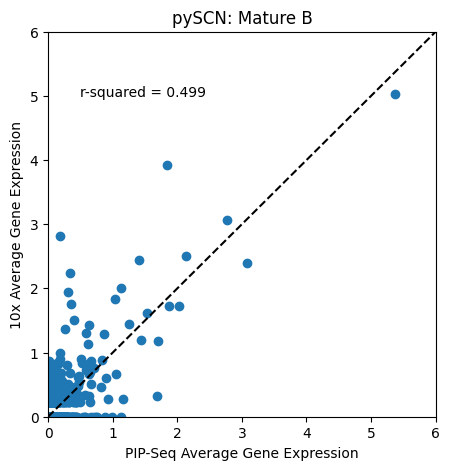

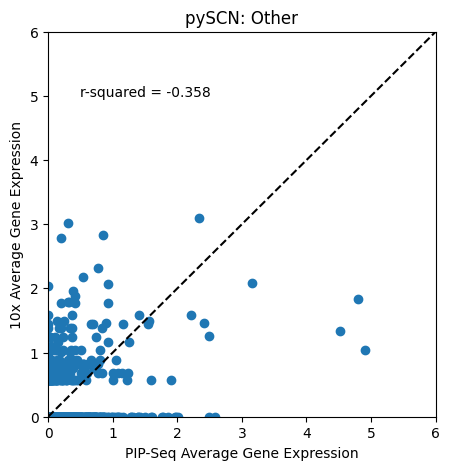

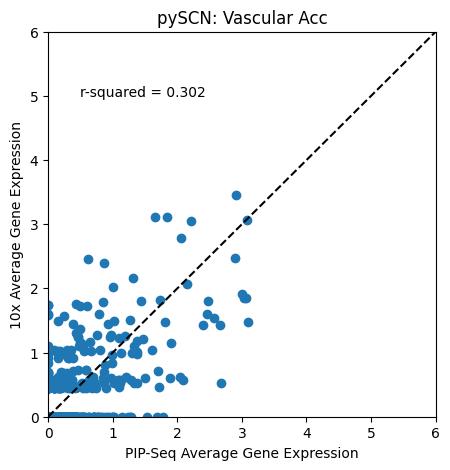

In [ ]:
with rc_context({'figure.figsize': (5, 5)}):
  plt.figure(1)
  for i in range(len(labels)):
    cell_name = labels[i]
    cell_expression = expression[i]
    plt.scatter(cell_expression[0], cell_expression[1])
    plt.plot([0,6],[0,6], 'k--')
    plt.xlabel("PIP-Seq Average Gene Expression")
    plt.ylabel("10x Average Gene Expression")
    plt.xlim(0,6)
    plt.ylim(0,6)
    plt.title("pySCN: {}".format(cell_name))
    plt.annotate("r-squared = {:.3f}".format(r2_score(cell_expression[0], cell_expression[1])), (0.5, 5))
    plt.show()

In [ ]:
labels, expression = averageExpression(adata_concat)

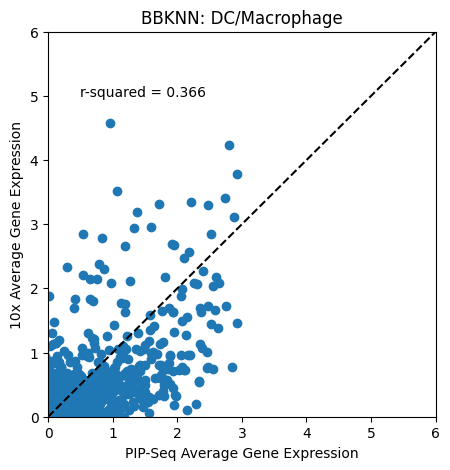

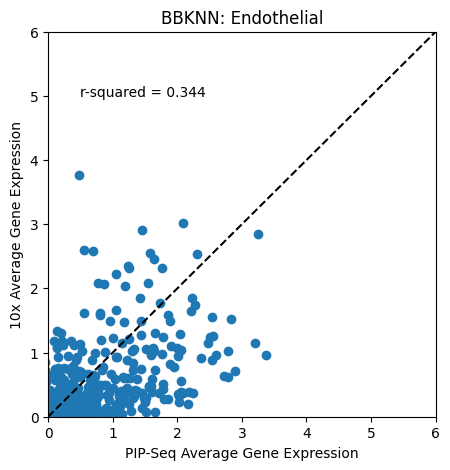

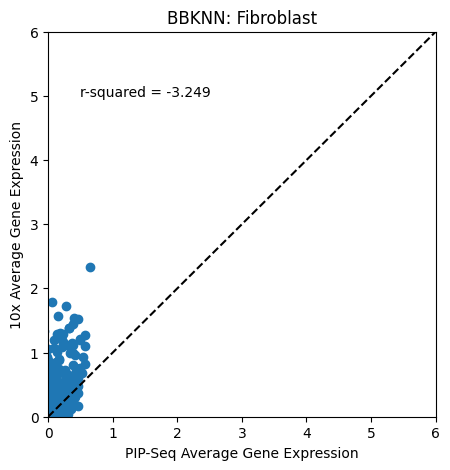

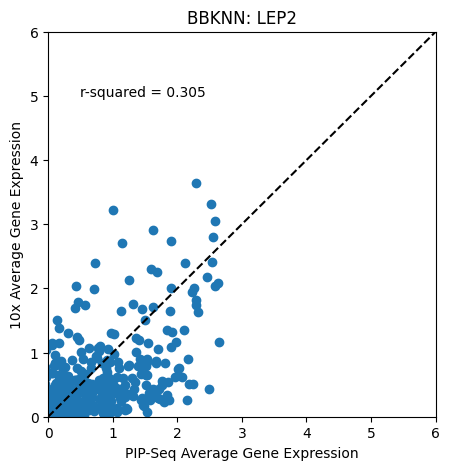

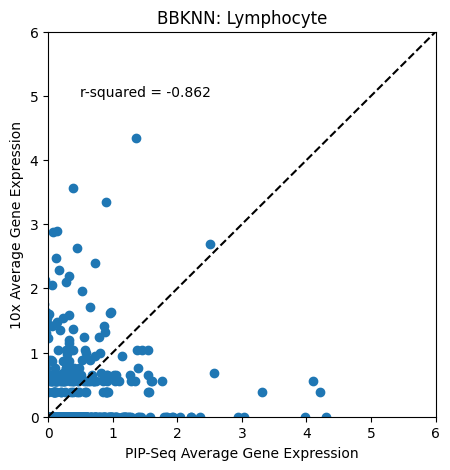

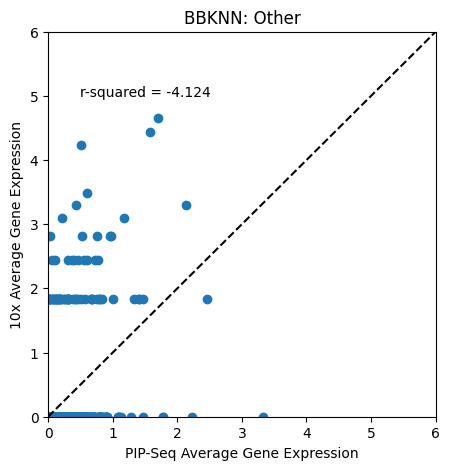

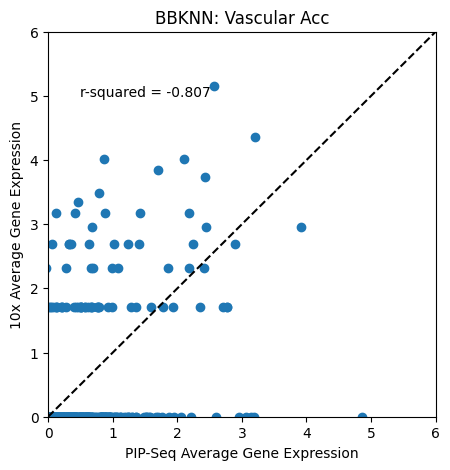

In [ ]:
with rc_context({'figure.figsize': (5, 5)}):
  plt.figure(1)
  for i in range(len(labels)):
    cell_name = labels[i]
    cell_expression = expression[i]
    plt.scatter(cell_expression[0], cell_expression[1])
    plt.plot([0,6],[0,6], 'k--')
    plt.xlabel("PIP-Seq Average Gene Expression")
    plt.ylabel("10x Average Gene Expression")
    plt.xlim(0,6)
    plt.ylim(0,6)
    plt.title("BBKNN: {}".format(cell_name))
    plt.annotate("r-squared = {:.3f}".format(r2_score(cell_expression[0], cell_expression[1])), (0.5, 5))
    plt.show()

In [ ]:
labels, expression = averageExpression(concat)

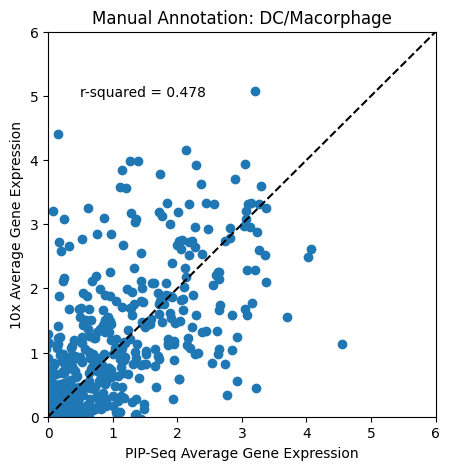

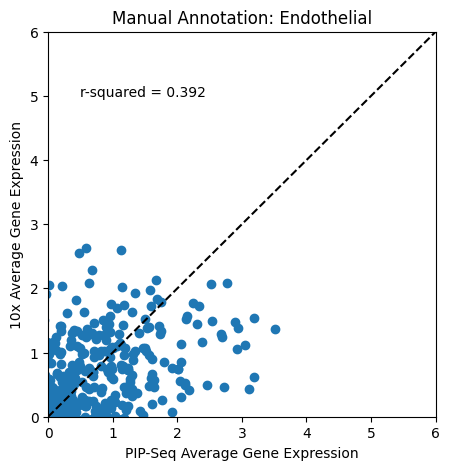

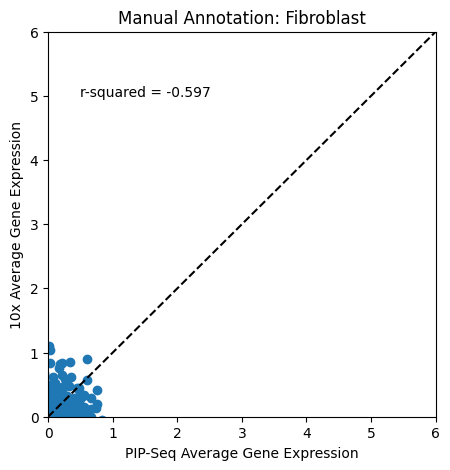

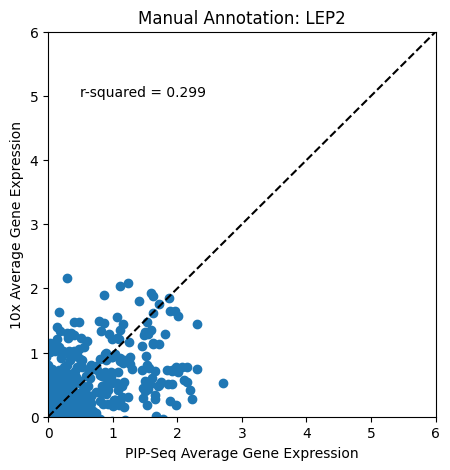

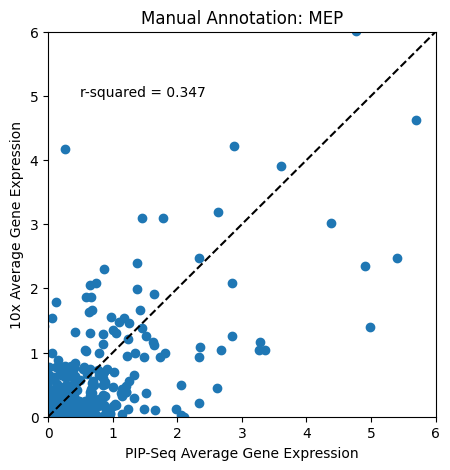

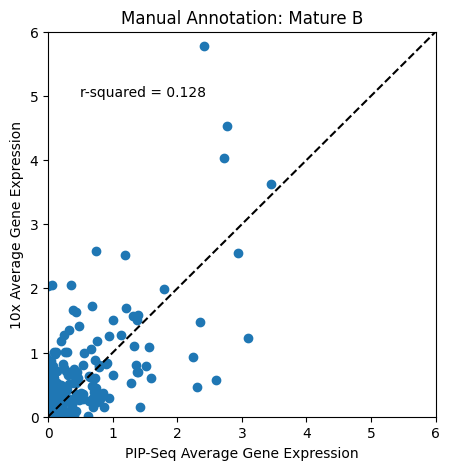

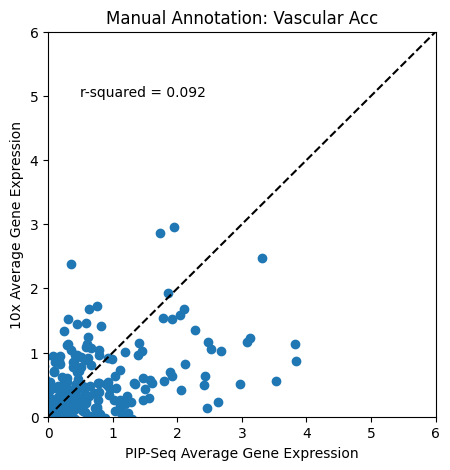

In [ ]:
with rc_context({'figure.figsize': (5, 5)}):
  plt.figure(1)
  for i in range(len(labels)):
    cell_name = labels[i]
    cell_expression = expression[i]
    plt.scatter(cell_expression[0], cell_expression[1])
    plt.plot([0,6],[0,6], 'k--')
    plt.xlabel("PIP-Seq Average Gene Expression")
    plt.ylabel("10x Average Gene Expression")
    plt.xlim(0,6)
    plt.ylim(0,6)
    plt.title("Manual Annotation: {}".format(cell_name))
    plt.annotate("r-squared = {:.3f}".format(r2_score(cell_expression[0], cell_expression[1])), (0.5, 5))
    plt.show()